In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
# sns.set_theme()
import GPy

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

In [14]:
GPy.models.GPLVM.optimize?

In [6]:
df_list = []
for dataset in range(3):
    for kernel in ("squared exponential", "rational quadratic", "gamma-exponential", "matern"):
        for n_samples in (100, 200, 500, 1000, 2000, 5000, 10000):
            for method in ('PCA', 'GPLVM', 'IKD'):
                df_list.append(pd.read_csv(f'outputs/{dataset}_{kernel}_{n_samples}_{method}.csv', index_col=0))
df = pd.concat(df_list, ignore_index=True)
df.d_observation = df.d_observation.astype(str)
df['dataset'] = df['dataset'].replace([0, 1, 2], ['Hard', 'Medium', 'Easy'])
df['kernel'] = df['kernel'].replace(['gamma-exponential', 'matern'], ['$\\gamma$-exponential', 'Matérn'])

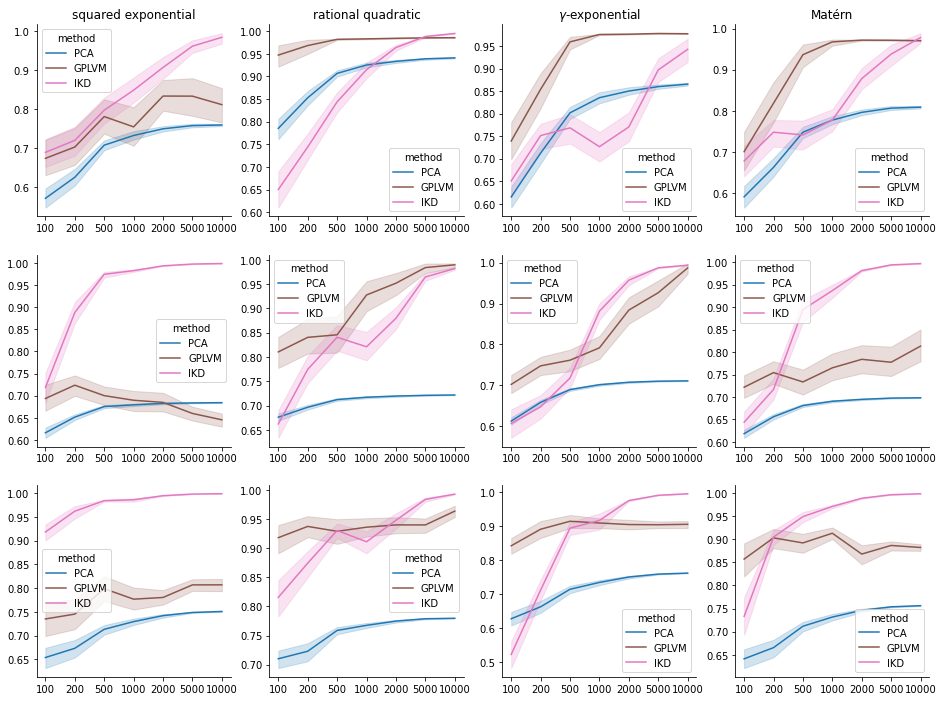

In [8]:
dataset_list = df.dataset.unique()
kernel_list = df.kernel.unique()
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
for i in range(3):
    for j in range(4):
        ax = sns.lineplot(x='d_observation', y='r2_true', hue='method', data=df[np.bitwise_and((df.dataset == dataset_list[i]).values, (df.kernel == kernel_list[j]).values)], palette=['C0', 'C5', 'C6'], ax=axs[i, j])
        ax.set(xlabel=None, ylabel=None)
        if i == 0:
            ax.set_title(kernel_list[j])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
fig.suptitle

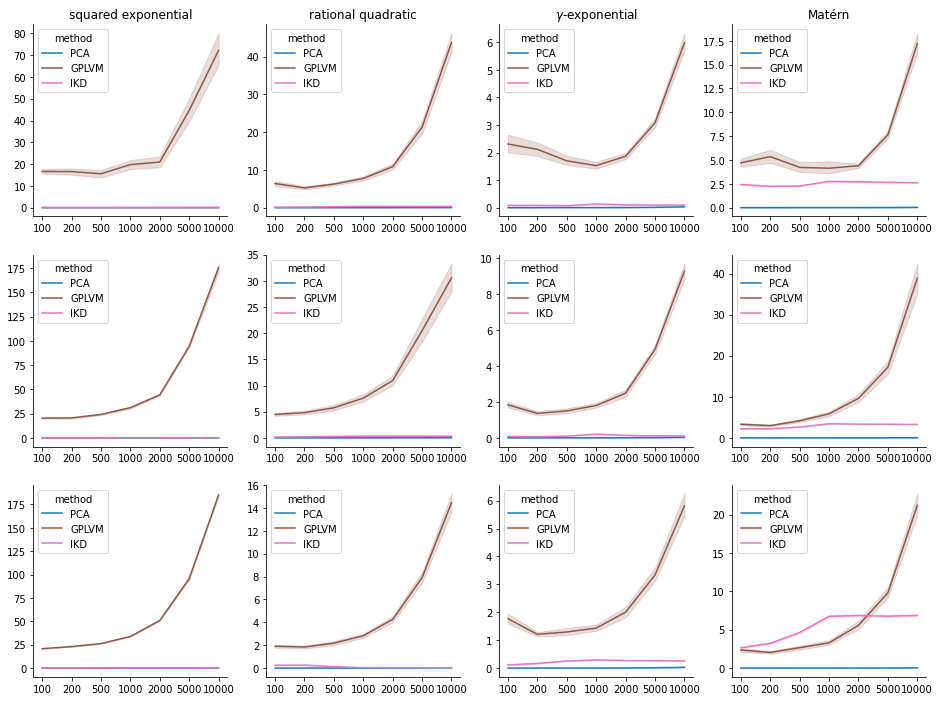

In [10]:
dataset_list = df.dataset.unique()
kernel_list = df.kernel.unique()
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
for i in range(3):
    for j in range(4):
        ax = sns.lineplot(x='d_observation', y='time', hue='method', data=df[np.bitwise_and((df.dataset == dataset_list[i]).values, (df.kernel == kernel_list[j]).values)], palette=['C0', 'C5', 'C6'], ax=axs[i, j])
        ax.set(xlabel=None, ylabel=None)
        if i == 0:
            ax.set_title(kernel_list[j])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

In [11]:
d_latent = 3 # latent dimensionality
dataset = 2
n_points = 100 # number of observations T
d_observation = 1000 # observation dimensionality
kernel = ["squared exponential", "rational quadratic", "gamma-exponential", "matern"][0]
extra_kernel_hyperparam = [None, 1, 1, 3/2][0]
variance = 1
length_scale = 0.5

z_true = datasets.generate_latent(d_latent, dataset, n_points=n_points, show=False)
cov_true = utils.kernel_cov_generator(z_true, kernel=kernel, variance=variance, length_scale=length_scale, extra_kernel_hyperparam=extra_kernel_hyperparam) # K, true kernel covariance matrix

In [24]:
np.random.seed(2)
m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
m_gplvm.optimize(messages=True, max_iters=1e4)
z_gplvm = m_gplvm.X.values

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s03  00005   8.713903e+04   6.467563e+09 
    00s09  00016   3.016735e+04   1.630606e+09 
    00s10  00019   1.438617e+04   6.910709e+08 
    00s19  00037  -1.467407e+04   3.191601e+09 
    01s69  00442  -5.135029e+04   4.654887e+09 
Runtime:     01s69
Optimization status: None

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

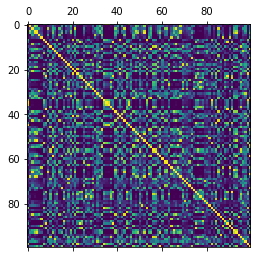

In [25]:
seed = 42
x = datasets.gaussian_process_generator(cov_true, d_observation, seed)
cov_samp_th = utils.filt_cov_samp(np.cov(x), variance=variance)
plt.matshow(cov_samp_th)

z_pca = PCA(n_components=d_latent).fit_transform(x)

m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
m_gplvm.optimize(max_iters=1e4)
z_gplvm = m_gplvm.X.values

z_le = SpectralEmbedding(n_components=d_latent).fit_transform(x)
z_ikd = core.ikd_blockwise(cov_samp_th, d_latent, kernel=kernel, variance=1, extra_kernel_hyperparam=extra_kernel_hyperparam, z_ref=z_le, clique_th_or_d_observation=d_observation)

evaluate.compare_latents(z_true, utils.align(z_true, z_pca), 'PCA')
evaluate.compare_latents(z_true, utils.align(z_true, z_gplvm), 'GPLVM')
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), 'IKD')

In [423]:
m_gplvm = GPy.models.GPLVM(x, 3, kernel=GPy.kern.Matern32(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
#m2.likelihood.variance.fix(.1)
m_gplvm

GPLVM.,value,constraints,priors
latent_mean,"(100, 3)",,
Mat32.variance,1.0,+ve,
Mat32.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [424]:
m_gplvm.optimize(messages=1, max_iters=5e4)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s09  00003   5.927174e+06   2.772194e+13 
    00s19  00006   2.561221e+06   1.052921e+15 
    03s23  00102   1.148699e+06   2.393286e+08 
    11s37  00358   1.112425e+06   3.586355e+06 
    26s77  00842   1.110205e+06   1.564372e+03 
Runtime:     26s77
Optimization status: Converged



In [425]:
z_gplvm = m_gplvm.X.values

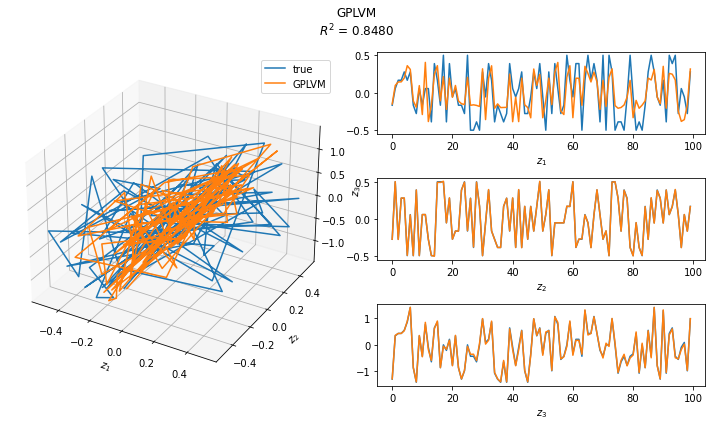

In [426]:
evaluate.compare_latents(z_true, utils.align(z_true, z_gplvm), 'GPLVM')